# **Recurrent Neural Network - Stock Prediction**

Le but de cet exercice est de prédire le cours de l'action Google. Rien que ça. Plus exactement : on veut prédire le prix de l'action Google à j+1 en utilisant un certain nombre de jours précédents. Allez en route !

## **1. Import et preprocessing des données**

1. Récupérer les données de Google sur Yahoo!Finance (c'est la colonne "close" qui nous intéressera). Prendre tout l'historique (depuis le 19 août 2004)
2. Pour vous rafraîchir un peu la mémoire :
>- les charger en un objet série temporelle avec pandas,
>- modifier la fréquence pour être en "jours ouvrables"
>- afficher la série
3. Créer vos échantillons d'entraînement et de test en précisant la stratégie utilisée
4. Scaler vos données. Pour les réseaux récurrents et plus généralement lorsqu'on utilise des fonctions d'activation sigmoïde, on suggère d'utiliser la normalisation (min-max)
5. Transformer vos données de sorte qu'elles puissent servir pour entraîner un réseau, c'est-à-dire qu'on veut une matrice X d'inputs et un vecteur y de targets. Pour ça, vous devez vous demander, qu'est-ce que je veux prédire et avec quoi ?
6. Quelle est la dimension des inputs pour un [réseau récurrent de keras](https://keras.io/api/layers/recurrent_layers/) (simple, LSTM, GRU, peu importe) ? Agissez en conséquence...c'est niquel ça fera même la transition avec la suite : lisez la doc, vous allez faire un RNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

# modif taille des figures
plt.rcParams["figure.figsize"] = (18,8)

In [2]:
# chargement des données et passage en timeseries
df = pd.read_csv("data/GOOG.csv",
                 usecols=['Date', 'Close'],
                 index_col='Date',
                 parse_dates=True)
df.index

DatetimeIndex(['2004-08-19', '2004-08-20', '2004-08-23', '2004-08-24',
               '2004-08-25', '2004-08-26', '2004-08-27', '2004-08-30',
               '2004-08-31', '2004-09-01',
               ...
               '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22',
               '2024-01-23', '2024-01-24', '2024-01-25', '2024-01-26',
               '2024-01-29', '2024-01-30'],
              dtype='datetime64[ns]', name='Date', length=4895, freq=None)

In [3]:
# fréquence jours ouvrables
df = df.asfreq('B', method='ffill')
df.index

DatetimeIndex(['2004-08-19', '2004-08-20', '2004-08-23', '2004-08-24',
               '2004-08-25', '2004-08-26', '2004-08-27', '2004-08-30',
               '2004-08-31', '2004-09-01',
               ...
               '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22',
               '2024-01-23', '2024-01-24', '2024-01-25', '2024-01-26',
               '2024-01-29', '2024-01-30'],
              dtype='datetime64[ns]', name='Date', length=5074, freq='B')

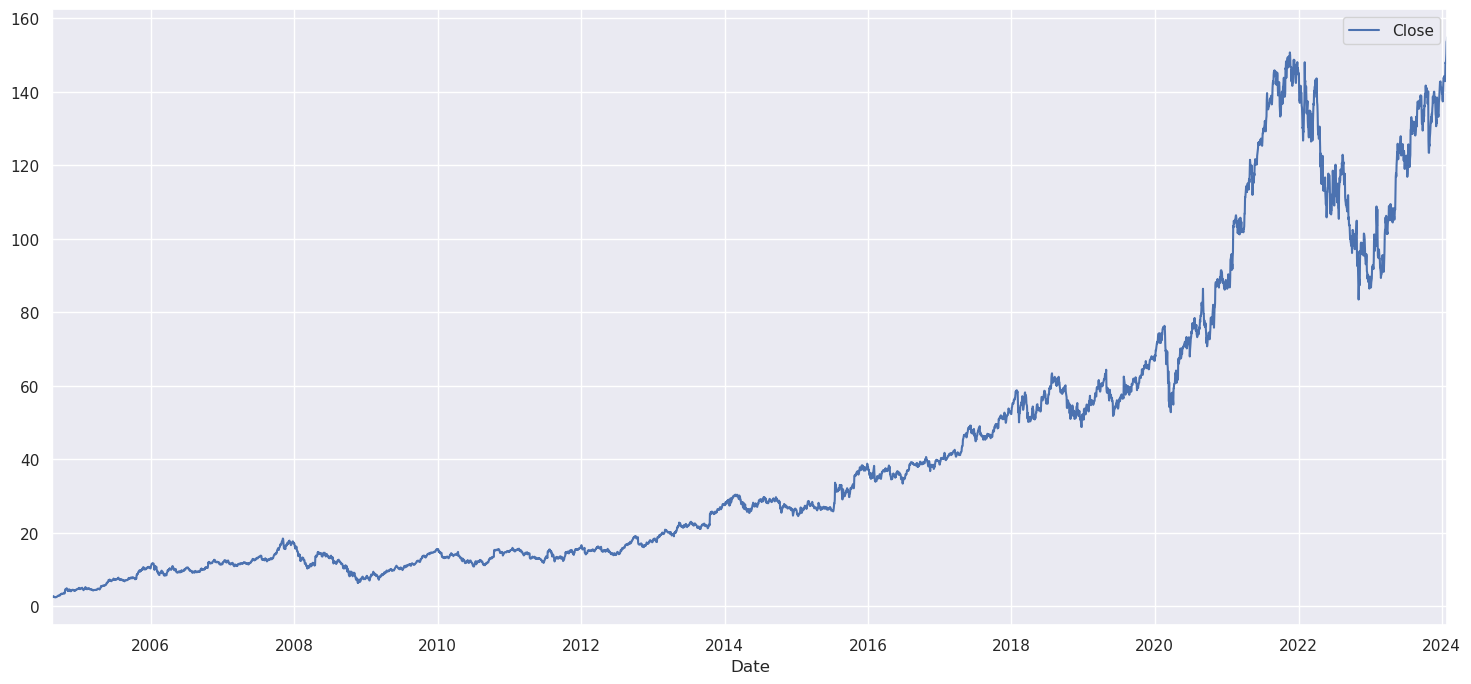

In [4]:
# affichage
df.plot();

In [5]:
# découpage train-test
# approche spécifique aux données temporelles
# on va cependant utiliser une méthode plus classique en ML/DL (voir plus bas)
train = df.loc[:"2023-08"]
test = df.loc["2023-09":]

print(train.shape, test.shape, df.shape)
print(train.index[-5:])
print(test.index[:5])

(4966, 1) (108, 1) (5074, 1)
DatetimeIndex(['2023-08-25', '2023-08-28', '2023-08-29', '2023-08-30',
               '2023-08-31'],
              dtype='datetime64[ns]', name='Date', freq='B')
DatetimeIndex(['2023-09-01', '2023-09-04', '2023-09-05', '2023-09-06',
               '2023-09-07'],
              dtype='datetime64[ns]', name='Date', freq='B')


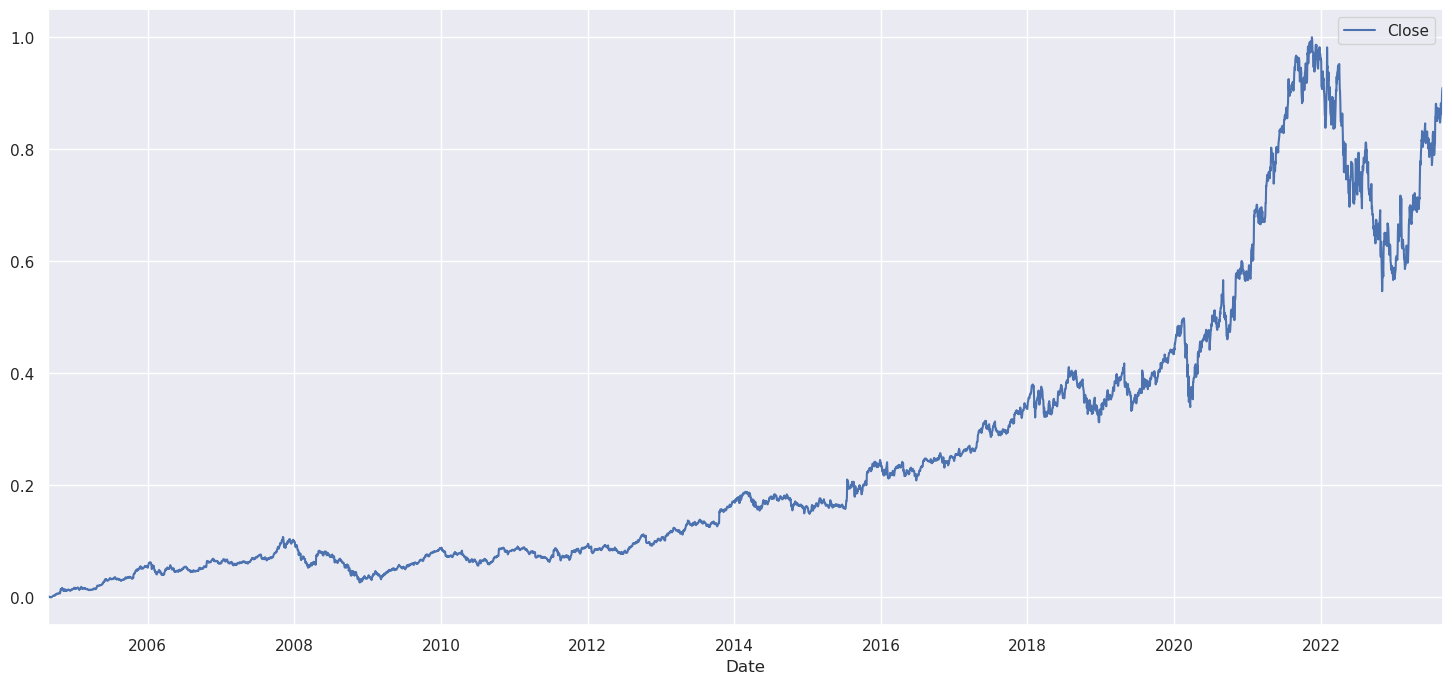

In [6]:
# normalisation min-max
from sklearn.preprocessing import MinMaxScaler
sc0 = MinMaxScaler().set_output(transform="pandas")
train = sc0.fit_transform(train)
test = sc0.transform(test)
train.plot();

In [7]:
# création d'une fonction qui construit X et y pour pouvoir utiliser un modèle ML/DL
# utilisation de n valeurs consécutives (n à fixer) pour prédire 1 valeur (la suivante)
from tqdm import tqdm

def build_train_test(data, timesteps=20):
    X, y = [], []
    
    for i in tqdm(range(timesteps, data.shape[0])):
        y.append(data.iloc[i,0])
        X.append(data.iloc[i-timesteps:i,0].values)
    
    return np.array(X), np.array(y)

X, y = build_train_test(df)
X_train0, y_train0 = build_train_test(train)
X_test0, y_test0 = build_train_test(test)
X.shape, y.shape, X_train0.shape, X_test0.shape, y_train0.shape, y_test0.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 6940.03it/s]


((5054, 20), (5054,), (4946, 20), (88, 20), (4946,), (88,))

In [8]:
# nouveau découpage train-test
# avantage = on a des données réparties aléatoirement sur toute la période 
# inconvénient = on peut moins bien visualiser les données sur un graphique
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4952, 20), (102, 20), (4952,), (102,))

In [9]:
# on refait la normalisation sur ce nouveau train.test
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [10]:
# Ajout d'une 3ème dimension à X_train
X_train0 = np.expand_dims(X_train0, axis=2)
X_test0  = np.expand_dims(X_test0, axis=2)
X_train  = np.expand_dims(X_train, axis=2)
X_test   = np.expand_dims(X_test, axis=2)
    
print(X_train0.shape, X_test0.shape, y_train0.shape, y_test0.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4946, 20, 1) (88, 20, 1) (4946,) (88,)
(4952, 20, 1) (102, 20, 1) (4952,) (102,)


## **2. Construction du réseau**

1. Continuer de regarder un peu la doc `keras` sur les RNN pour savoir quelles couches utiliser
2. En reprenant toujours les mêmes étapes (initialisation, ajout de couches cachées, couche de sortie, paramètres d'entraînement, entraînement), construire un RNN comprenant plusieurs couches LSTM empilées.  
Ne pas oublier de gérer le sur-apprentissage s'il y en a...

In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Initialisation
rnn = Sequential()
# 1ère couche LSTM
rnn.add(LSTM(units=30, input_shape=(X_train.shape[1], X_train.shape[2])))
# Output
rnn.add(Dense(units=1))
# Paramètres d'entraînement
rnn.compile(optimizer='adam', loss='mse')
# Structure du modèle
print(rnn.summary())
# Entraînement
rnn.fit(X_train, y_train, epochs=30, batch_size=32)

2024-02-01 12:03:17.255583: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 3871 (15.12 KB)
Trainable params: 3871 (15.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/30
155/155 [==============================] - 3s 7ms/step - loss: 2868.6633
Epoch 2/30
155/155 [==============================] - 1s 7ms/step - loss: 2400.6758
Epoch 3/30
155/155 [==============================] - 1s 7ms/step - loss: 2148.8369
Epoch 4/30
155/155 [==============================] - 1s 7ms/step - loss: 1972.3857
Epoch 5/30
155/155 [==============================] - 1s 7ms/step - loss: 184

In [12]:
rnn0 = Sequential()
rnn0.add(LSTM(units=30, input_shape=(X_train0.shape[1], X_train0.shape[2])))
rnn0.add(Dense(units=1))
rnn0.compile(optimizer='adam', loss='mse')
rnn0.fit(X_train0, y_train0, epochs=30, batch_size=32)

Epoch 1/30
155/155 [==============================] - 3s 7ms/step - loss: 0.0059
Epoch 2/30
155/155 [==============================] - 1s 7ms/step - loss: 1.7243e-04
Epoch 3/30
155/155 [==============================] - 1s 7ms/step - loss: 1.6321e-04
Epoch 4/30
155/155 [==============================] - 1s 7ms/step - loss: 1.5972e-04
Epoch 5/30
155/155 [==============================] - 1s 7ms/step - loss: 1.5920e-04
Epoch 6/30
155/155 [==============================] - 1s 7ms/step - loss: 1.4955e-04
Epoch 7/30
155/155 [==============================] - 1s 7ms/step - loss: 1.4107e-04
Epoch 8/30
155/155 [==============================] - 1s 7ms/step - loss: 1.4842e-04
Epoch 9/30
155/155 [==============================] - 1s 7ms/step - loss: 1.3424e-04
Epoch 10/30
155/155 [==============================] - 1s 7ms/step - loss: 1.2665e-04
Epoch 11/30
155/155 [==============================] - 1s 8ms/step - loss: 1.2845e-04
Epoch 12/30
155/155 [==============================] - 1s 7ms/step 

In [13]:
rnn.predict(X_test)

4/4 [==============================] - 0s 3ms/step


array([[39.8669   ],
       [10.659313 ],
       [50.07336  ],
       [16.84454  ],
       [86.35701  ],
       [44.51749  ],
       [ 9.97496  ],
       [99.137115 ],
       [13.322351 ],
       [11.810349 ],
       [99.236855 ],
       [17.416344 ],
       [99.20723  ],
       [45.26575  ],
       [99.083145 ],
       [14.008248 ],
       [28.241018 ],
       [99.22878  ],
       [37.580605 ],
       [10.688162 ],
       [15.715214 ],
       [99.23987  ],
       [19.384615 ],
       [ 9.934274 ],
       [17.61177  ],
       [14.372332 ],
       [11.937719 ],
       [99.23876  ],
       [19.591806 ],
       [14.116931 ],
       [16.80512  ],
       [12.108416 ],
       [12.619808 ],
       [98.95389  ],
       [ 7.8611584],
       [14.567347 ],
       [64.39993  ],
       [ 7.808485 ],
       [74.04176  ],
       [25.100645 ],
       [11.319511 ],
       [99.23778  ],
       [15.033302 ],
       [99.23864  ],
       [99.23083  ],
       [13.606171 ],
       [97.293144 ],
       [99.23

## **3. Prédiction, évaluation et visualisation**

On va essayer dans cette partie de prédire les 2 derniers mois.

**Première approche :** une première méthode est de prédire chaque jour à partir des dernières vraies valeurs. Cela a du sens puisque notre modèle est construit pour ça : prédire la valeur de l'action à j+1 à partir d'un nombre de jours précédents fixés. En revanche cela veut dire qu'on utilise à chaque fois les vraies valeurs de l'échantillon test pour prédire la suivante. Pour essayer d'être plus clair :  
>- on a un modèle entraîné avec les données jusqu'au 31/12/2021 et on veut prédire les valeurs de 2022
>- notre modèle est fait pour prédire un jour à partir des précédents, le 31/12 on va donc prédire le 01/01 à partir des données des jours précédents
>- ensuite, le lendemain, le 01/01, on va prédire le 02/01 en utilisant la vraie valeur du 01/01 qu'on aura observée depuis ainsi que les précédentes
>- ensuite, le lendemain, le 02/01, on va prédire le 03/01 en utilisant les vraies valeurs des 01/01 et 02/01 et les précédentes
>- etc...
>
> Ce qu'on peut reprocher à cette méthode c'est de ne pas utiliser les nouvelles infos dans la construction du modèle mais uniquement pour la prédiction. Ça a un petit côté paradoxal mais en même temps on a pas forcément envie de réentraîner notre modèle tous les jours avec juste une seule valeur en plus.
>
>1. Le premier travail va être de formater les inputs de test pour qu'ils soient au même format que ceux de l'entraînement du modèle. Il faut donc répéter les opérations qu'on a faites pour le train. Avec quelques modifications quand même. hésitez pas à prendre un papier un crayon si ça chauffe trop...
>>- définir un objet `inputs` qui contient toutes les valeurs dont vous aurez besoin (donc les données du test + les n dernières valeurs du train nécessaires à la prédiction des n premières valeurs du test). Vous pouvez pour ça utiliser certaines méthodes des objets datetime de pandas.
>>- une fois que c'est fait, il vous reste plus qu'à normaliser et reconstruire votre `X_test` de la même manière que votre `X_train`
>2. Évaluer les prédictions avec une ou plusieurs métriques adaptées
>3. Afficher les prédictions sur un beau graphique

**Deuxième approche :** la deuxième possibilité consiste à prédire toutes la période de test à partir des infos au 31/12/2021. Cela pourrait avoir du sens si on veut savoir comment va évoluer la tendance à moyen terme (ou en tout cas à plus que j+1).
>- on a un modèle entraîné avec les données jusqu'au 31/12/2021 et on veut prédire les valeurs de 2022
>- notre modèle est fait pour prédire un jour à partir des précédents, le 31/12 on va donc prédire le 01/01 à partir des données des jours précédents
>- puis, toujours le 31/12, on va prédire le 02/01 en utilisant la valeur prédite du 01/01 ainsi que les précédentes
>- puis, toujours le 31/12, on va prédire le 03/01 en utilisant les valeurs prédites des 01/01 et 02/01 ainsi que les précédentes
>- etc...
>
> Le modèle qu'on a construit est prévu pour ne prédire qu'à un jour donc on réutilise la prédiction comme input pour la prédiction du jour suivant. Le problème est qu'on multiplie ainsi les erreurs qui s'accumule un jour après l'autre. Cette méthode ne sera donc a priori pas très convaincante ou en tout cas pas sur une longue période...mais on va le faire quand même !
>
> Une autre approche, à tester pour en comparer l'efficacité mais certainement meilleure, serait de construire un modèle qui prédit plusieurs jours à partir des précédents.
>
>1. On va de nouveau formater les inputs mais différement bien sûr.
>>- définir un objet `inputs` qui contient toutes les n dernières valeurs du train nécessaires à la prédiction
>>- faire la prédiction pour le 1er jour
>>- ajouter cette prédiction dans votre objet `inputs` et supprimer la 1ère valeur dont on aura plus besoin
>>- faire la prédiciton du second jour puis l'insérer dans votre `inputs`
>>- etc jusqu'à avoir prédit toutes les valeurs de 2022
>2. Évaluer et afficher les prédictions

**Troisième approche :** après l'échec de la deuxième option, on va mettre en place une 3ème. L'objectif est de construire un modèle RNN (many-to-many) qui pour une séquence d'entrée (longueur à choisir) va prédire une séquence d'un mois (c'est-à-dire 20 jours ouvrés).

## **4. Amélioration du modèle**

En revenant sur la première approche, essayer d'amélorier le modèle.

Quelques pistes qui peuvent évidemment être combinées mais tout ça étant coûteux en temps, vous ne pourrez pas tout tester :
- Plus de données, quand c'est possible cf point 5
- Augmenter le nombre de "timesteps" pour regarder plus loin dans le passé
- Ajouter d'autres variables : par exemple on pourrait ajouter des actions d'autres entreprises dont l'action pourrait être corrélée à celle de Google
- Compléxifier le réseau : plus de couches/neurones
- Ajustement des hyperparamètres

## **5. Ajout de variables supplémentaires**

Comme évoqué, on pourrait vouloir ajouter d'autres variables pour améliorer les performances de notre modéle. Dans cette partie, il s'agit de mettre en oeuvre un RNN avec plusieurs variables. Sans aller chercher l'action d'une autre entreprise des GAFA par exemple, on va se contenter pour simplifier ici d'uitiliser les autres variables disponibles dans le dataset (Open, High et Low).

1. À vous de modifier votre code pour prendre en compte dans votre modèle les 4 informations Open, High, Low et Close.
2. Comparer les prédictions obtenues (et les temps d'exécution !)